# Telco Customer Churn

#### Libraries and global settings

In [97]:
import time as tm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve

%matplotlib inline

In [98]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

MAIN_COLOR = 'darkochid'

SEED = 42
N_FOLDS = 5

## Read data

In [99]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


No null data

In [101]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Preprocess data

In [102]:
df.TotalCharges.value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

There is 11 missing values in `TotalCharges`. Fill missing values as 0 now for converting as numerical.

In [103]:
df.loc[df.TotalCharges == ' ', 'TotalCharges'] = 0
df.TotalCharges = df.TotalCharges.astype(float)

Does exist `MonthlyCharges` when `TotalCharges` is 0?

In [104]:
df[['MonthlyCharges', 'TotalCharges']].sort_values('TotalCharges').head(15)

,MonthlyCharges,TotalCharges
3826,25.35,0.00
5218,19.70,0.00
4380,20.00,0.00
753,20.25,0.00
488,52.55,0.00
1082,25.75,0.00
6754,61.90,0.00
936,80.85,0.00
1340,56.05,0.00
6670,73.35,0.00


## EDA

In [105]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [106]:
df.customerID.value_counts()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

`customerID` if unique parameter

In [107]:
df.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

`SeniorCitizen` can be threated as categorical feature

In [108]:
TARGET = 'Churn'

CAT_FEATURES = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'
]

NUM_FEATURES = [
    'tenure', 'MonthlyCharges', 'TotalCharges'
]

ALL_FEATURES = CAT_FEATURES + NUM_FEATURES

### Target

In [109]:
df[TARGET].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Data is unbalanced, so recommend to upsamle minor class

### Categorical features

In [110]:
df[TARGET] = df[TARGET].apply(lambda x: 1 if x == 'Yes' else 0)

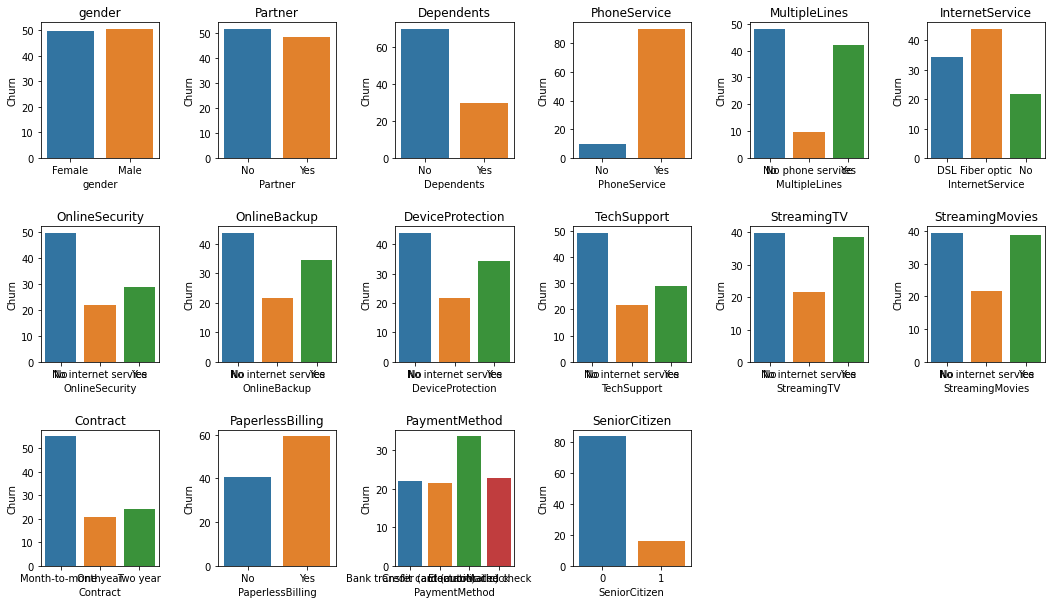

In [111]:
plt.figure(figsize=(18,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, col in enumerate(CAT_FEATURES):
    plt.subplot(3, 6, i+1)
    sns.barplot(x=col, y=TARGET, data=df,
                estimator=lambda x: len(x) / len(df) * 100,
                order=np.sort(df[col].unique()))
    plt.title(col)
plt.show()

### Numerical features

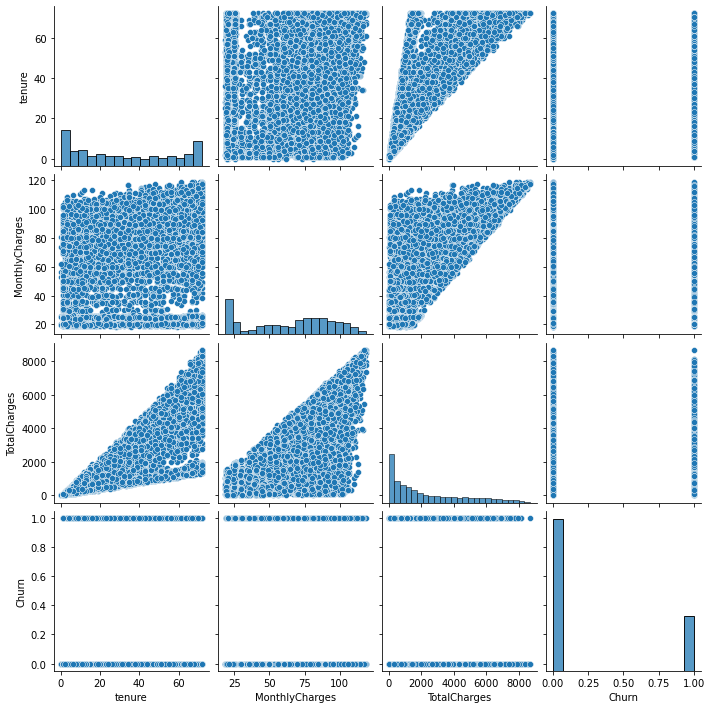

In [112]:
sns.pairplot(df[[
    *NUM_FEATURES,
    TARGET
]])

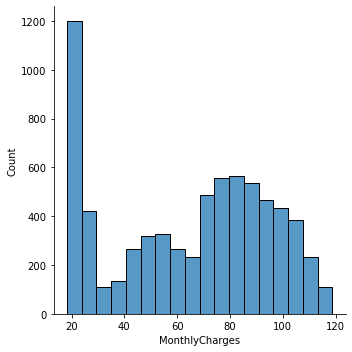

In [113]:
sns.displot(df.MonthlyCharges)

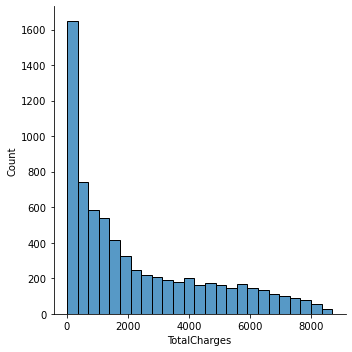

In [114]:
sns.displot(df.TotalCharges)

`TotalCharges` values distribution is highly right sqewed

#### Correlation matrix of numerical features

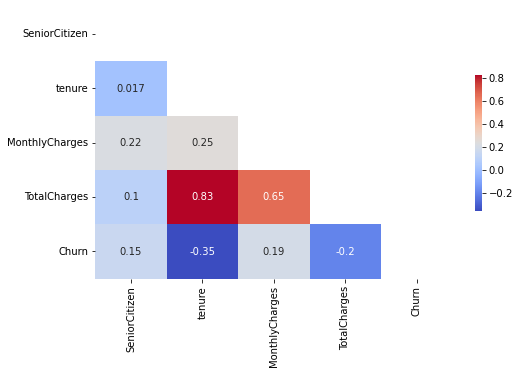

In [115]:
corrMatrix = df.corr(method='pearson', min_periods=1)
plt.figure(figsize=(8,5))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

We observe strong direct correlation of `tenture` - `TotalCharges` and, less but high too, `MonthlyCharges` - `TotalCharges`

### Feature engineering

First of all split data to train and test sets for avoiding leaking

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df[ALL_FEATURES], df[TARGET], test_size=0.2, random_state=SEED)

Upsample data of minority class in train data

In [117]:
df_train = X_train
df_train[TARGET] = y_train

df_majority = df_train[df_train[TARGET]==0]
df_minority = df_train[df_train[TARGET]==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=df_minority.shape[0] * 2,
                                 random_state=SEED)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train = df_upsampled.drop(columns=TARGET)
y_train = df_upsampled[TARGET]

print(y_train.value_counts())

0    4138
1    2992
Name: Churn, dtype: int64


Fill missing values and 0 values of `TotalCharges` as mean `MonthlyCharges` corrected by ratio of mean `MonthlyCharges` and `TotalCharges`

In [118]:
mean_monthly = X_train.MonthlyCharges.mean()
mean_total = X_train[X_train.TotalCharges != ' '].TotalCharges.astype(float).mean()
total_ratio = mean_total / mean_monthly
print(f"Monthly mean: {mean_monthly:.2f}  Total mean: {mean_total:.2f}  Ratio: {total_ratio:3f}")

X_train.TotalCharges = np.where((X_train.TotalCharges == ' ') | (X_train.TotalCharges == 0.0),
                                X_train.MonthlyCharges * total_ratio,
                                X_train.TotalCharges)

Monthly mean: 66.88  Total mean: 2133.98  Ratio: 31.906748


Let's made new features as `TotalCharges` / `tenure`

In [119]:
X_train['TotalCharges_tenure'] = X_train.tenure / X_train.TotalCharges

NUM_FEATURES.append('TotalCharges_tenure')

Let's apply log transformation for sqewed `TotalCharges`

In [120]:
transformer = FunctionTransformer(np.log1p)
X_train['TotalCharges'] = transformer.fit_transform(X_train['TotalCharges'])

scaler = StandardScaler()
X_train[NUM_FEATURES] = scaler.fit_transform(X_train[NUM_FEATURES])

encoder = OneHotEncoder(handle_unknown='error', drop='if_binary', sparse=False)
train_ohe = encoder.fit_transform(X_train[CAT_FEATURES])
X_train[encoder.get_feature_names_out()] = train_ohe

ALL_FEATURES_FINAL = [*NUM_FEATURES, *encoder.get_feature_names_out()]


In [121]:
# # preprocess_pipe = Pipeline(steps=[('transformer', transformer), ('scaler', scaler)])
# numeric_transformer = Pipeline(
#     steps=[('transformer', transformer), ("scaler", )]
# )

# class FeatureCreator(BaseEstimator, TransformerMixin):
#     def __init__(self) -> None:
#         super().__init__()
#     def fit(self, X, y=None):
#         return self 
#     def transform(self, X, y=None):
#         X['TotalCharges_tenure'] = X.TotalCharges / X.tenure
#         return X

# feature_engineering = FeatureCreator()
# transformer = FunctionTransformer(np.log1p)
# scaler = StandardScaler()
# encoder = OneHotEncoder(handle_unknown='error', drop='if_binary')

# preprocessor = ColumnTransformer(
#     transformers=[
#         # ('feature_engineering', feature_engineering, ['TotalCharges', 'tenure']), 
#         ("log", transformer, ['TotalCharges'])
#         ("scaler", scaler, NUM_FEATURES),
#         ("cat", encoder, CAT_FEATURES),
#     ]
# )

# pipe = Pipeline(
#     steps=[("preprocessor", preprocessor)]
# )

## Model

In [122]:
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'max_iter': [10000],
            'C': (0.5, 1, 5, 10, 50),
            'l1_ratio': (0.0, 0.5, 0.75, 0.9, 1.0)
        }
    },

    'Ridge Classifier': {
        'model': RidgeClassifier(),
        'params': {
            'alpha': (0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0)
        }
    },

    'SVM': {
        'model': SVC(),
        'params' : {
            'kernel': ('linear', 'rbf'),
            'C': (1, 5, 10)
        }  
    },

    'Desicion Tree': {
        'model': DecisionTreeClassifier(), 
        'params' : {
            'criterion': ('gini', 'log_loss'),
            'max_depth': (5, 6, 7),
            'min_samples_leaf': (2, 4),
            'min_samples_split': (3, 4),
            'random_state': [SEED]
        }  
    },

   'Random Forrest': {
       'model': RandomForestClassifier(),
       'params' : {
           'n_estimators': (100, 150, 200),
           'max_depth': [5],
           'min_samples_leaf': (2, 3, 4),
           'min_samples_split': (3, 4),
           'n_jobs': [-1],
           'random_state': [SEED]
       }  
   }, 

    'Ada Boost': {
        'model': AdaBoostClassifier(),
        'params' : {
            'n_estimators': (50, 100, 150, 200, 300),
            'learning_rate': (0.1, 0.2, 0.5, 0.75, 0.9, 1.0, 1.5, 2.0),
            'random_state': [SEED]
        }  
    },
}

In [123]:
for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    clf = GridSearchCV(model_params[model_name]['model'],
                        model_params[model_name]['params'],
                        cv=N_FOLDS,
                        scoring='f1',
                        return_train_score=False, 
                        n_jobs=-1
    )
    clf.fit(X_train[ALL_FEATURES_FINAL], y_train)
    model_params[model_name]['best_params'] = clf.best_params_
    print(clf.best_params_, clf.best_score_)
    end_time = tm.time() - start
    iter_time = end_time / sum([len(model_params[model_name]['params'][key]) for key in model_params[model_name]['params']])
    print(f"Overal fit time: {end_time:.1f}s  fit time per iter: {iter_time:.1f}s\n")

LogisticRegression
{'C': 50, 'l1_ratio': 0.0, 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'} 0.7247394255541671
Overal fit time: 44.9s  fit time per iter: 3.5s

Ridge Classifier
{'alpha': 1.0} 0.730581778314841
Overal fit time: 0.2s  fit time per iter: 0.0s

SVM
{'C': 10, 'kernel': 'rbf'} 0.7697241503716609
Overal fit time: 15.2s  fit time per iter: 3.0s

Desicion Tree
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'random_state': 42} 0.7426727231002273
Overal fit time: 0.6s  fit time per iter: 0.1s

Random Forrest
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42} 0.7284837663499866
Overal fit time: 10.5s  fit time per iter: 1.0s

Ada Boost
{'learning_rate': 1.5, 'n_estimators': 300, 'random_state': 42} 0.7403625268563443
Overal fit time: 34.9s  fit time per iter: 2.5s



## Test

In [124]:
X_test.TotalCharges = np.where((X_test.TotalCharges == ' ') | (X_test.TotalCharges == 0.0), X_test.MonthlyCharges * total_ratio, X_test.TotalCharges)
X_test['TotalCharges_tenure'] = X_test.tenure / X_test.TotalCharges
X_test['TotalCharges'] = transformer.transform(X_test['TotalCharges'])
X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
test_ohe = encoder.transform(X_test[CAT_FEATURES])
X_test[encoder.get_feature_names_out()] = test_ohe

for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    model = model_params[model_name]['model']
    model.set_params(**model_params[model_name]['best_params'])
    model.fit(X_train[ALL_FEATURES_FINAL], y_train)
    print(f"Fit time: {(tm.time() - start):.3f}s")
    start = tm.time()
    predictions = model.predict(X_test[ALL_FEATURES_FINAL])
    print(f"Predict time: {(tm.time() - start):.3f}s")
    print(classification_report(y_test, predictions))
    print('\n')


LogisticRegression
Fit time: 0.537s
Predict time: 0.004s
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.58      0.76      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.80      1409



Ridge Classifier
Fit time: 0.009s
Predict time: 0.002s
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1036
           1       0.58      0.77      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.80      1409



SVM
Fit time: 2.189s
Predict time: 0.255s
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1036
           1       0.56      0.72      0.63       373

    accuracy            

All models have aporximately same score on test set but **random forrest classifier** is slightly better with acceptable fit and prediction time

### ROC-AUC

Let's check ROC-AUC of selected model

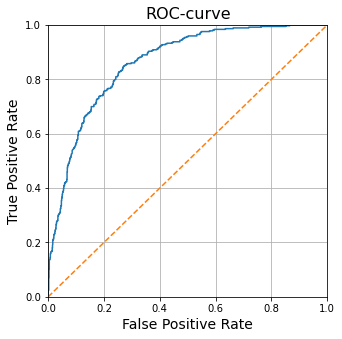

In [125]:
def plot_roc_curve(fpr=None, tpr=None):
    """Plot custom histogram"""
    plt.figure(figsize=(5,5))
    plt.title('ROC-curve', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    plt.plot(fpr, tpr)

    # ROC-curve of random model
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.grid(True)
    
    plt.show()
    
model = RandomForestClassifier()
model.set_params(**{'max_depth': 5,
                'min_samples_leaf': 3,
                'min_samples_split': 3,
                'n_estimators': 100,
                'n_jobs': -1,
                'random_state': SEED})
model.fit(X_train[ALL_FEATURES_FINAL], y_train)
probabilities_valid = model.predict_proba(X_test[ALL_FEATURES_FINAL])
fpr, tpr, thresholds = roc_curve(y_test, probabilities_valid[:,1])
plot_roc_curve(fpr, tpr)

## Conclusion

Random Forrest as model classifier is best with hyper parameters:
- 'max_depth': 5,
- 'min_samples_leaf': 3,
- 'min_samples_split': 3,
- 'n_estimators': 100,
- 'n_jobs': -1,
- 'random_state': SEED